# Example Notebook: Neuron Synapse Competition

## Load in and Wrangle Training Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

In [ ]:
data.head()

#### Basic info on these dataframes

In [3]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Assuming 'data' is your DataFrame and 'pre_rf_x', 'pre_rf_y' are your column names
# Calculate the point density
x = data['pre_rf_x']
y = data['pre_rf_y']
values = np.vstack([x, y])
kernel = gaussian_kde(values)
densities = kernel(values)

# Generate the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=densities, s=100 * densities, alpha=0.5, edgecolor='')
plt.title('Density Scatter Plot of Pre Features')
plt.xlabel('pre_rf_x')
plt.ylabel('pre_rf_y')
plt.colorbar(scatter, label='Density')
plt.show()


KeyboardInterrupt: 

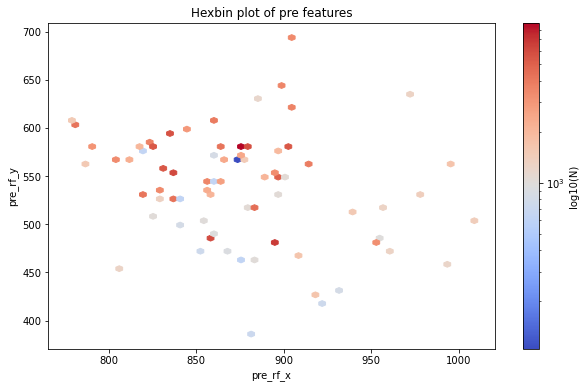

In [118]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Create a hexbin map with a color bar
hb = plt.hexbin(data['pre_rf_x'], data['pre_rf_y'], gridsize=60, cmap='coolwarm', bins='log')

# Add title and labels
plt.title('Hexbin plot of pre features')
plt.xlabel('pre_rf_x')
plt.ylabel('pre_rf_y')

# Add a color bar
cb = plt.colorbar(hb)
cb.set_label('log10(N)')  # Where N is the count in each hexbin

plt.show()


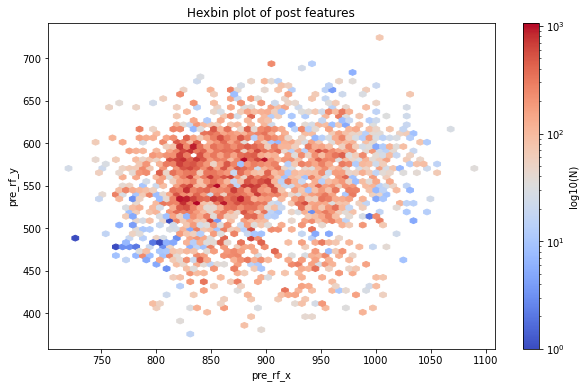

In [117]:
plt.figure(figsize=(10, 6))

# Create a hexbin map with a color bar
hb = plt.hexbin(data['post_rf_x'], data['post_rf_y'], gridsize=60, cmap='coolwarm', bins='log')

# Add title and labels
plt.title('Hexbin plot of post features')
plt.xlabel('pre_rf_x')
plt.ylabel('pre_rf_y')

# Add a color bar
cb = plt.colorbar(hb)
cb.set_label('log10(N)')  # Where N is the count in each hexbin

plt.show()


See the documentation for additional information on these features.  The main dataframe contains features for each potential synapse (each row).  The outcome to predict is 'connected'.  Note that many of the raw features in this dataframe will not be directly useful for prediction (e.g. x,y,z coordiantes, pre- and post-synapse neuron ID and etc.).  You will need to creatively engineer new features that will be more useful for prediction.

The additional information on feature weights and morphological embeddings are given for each separate neuron (the neuron ID is matched with that in the main dataframe).  These will need to be merged with the other data to create training and test sets. 

#### Merge Data

Before merging, we concatenate the feature weights and morphological embeddings into np.array's to decrease memory usage.

In [4]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [5]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [6]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

Data Size: (185832, 34)

Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null

In [78]:
data.head()

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,post_nucleus_z,pre_nucleus_id,post_nucleus_id,connected,pre_feature_weights,post_feature_weights,pre_morph_embeddings,post_morph_embeddings,fw_similarity,projection_group
0,42593,1187660,411978,1089020,1187390,412220,1089160,304.185,353043.0,1182170.0,...,919560,557121,518848,False,"[0.40828925, 0.051097646, -0.02682111, 0.04239...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.3733156323432922, 0.209817960858345, -0.123...","[1.0723994970321655, -0.7540942430496216, 0.11...",0.127256,RL->RL
1,42594,1204580,682542,873138,1204640,682870,873890,725.431,244156.0,914243.0,...,919560,557121,518848,False,"[0.40828925, 0.051097646, -0.02682111, 0.04239...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.3733156323432922, 0.209817960858345, -0.123...","[1.0723994970321655, -0.7540942430496216, 0.11...",0.127256,RL->RL
2,42595,1191790,403683,1093180,1188590,402414,1092660,3423.030,363829.0,1171820.0,...,919560,557121,518848,False,"[0.40828925, 0.051097646, -0.02682111, 0.04239...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.3733156323432922, 0.209817960858345, -0.123...","[1.0723994970321655, -0.7540942430496216, 0.11...",0.127256,RL->RL
3,42596,1184320,419286,1082930,1186620,419721,1085540,3442.390,344267.0,1192340.0,...,919560,557121,518848,False,"[0.40828925, 0.051097646, -0.02682111, 0.04239...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.3733156323432922, 0.209817960858345, -0.123...","[1.0723994970321655, -0.7540942430496216, 0.11...",0.127256,RL->RL
4,42597,1189150,673302,944202,1188790,677771,942901,4442.380,313630.0,788566.0,...,919560,557121,518848,False,"[0.40828925, 0.051097646, -0.02682111, 0.04239...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.3733156323432922, 0.209817960858345, -0.123...","[1.0723994970321655, -0.7540942430496216, 0.11...",0.127256,RL->RL


## Basic Exploratory Analysis

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

### Unbalanced Data

The outcomes, the adps that form a connection or synapse ('connected'==True) and the adps that do not synapse ('connected'==False), are unbalanced:

In [8]:
print("Number Connected (Synapses):",data['connected'].sum())

print("\nNumber Not Connected:",(~data['connected']).sum())

Number Connected (Synapses): 1366

Number Not Connected: 184466


The number of presynaptic neurons and postsynaptic neurons are also unbalanced:

In [9]:
print(f"All the adps are from {data['pre_nucleus_id'].nunique()} pre- neurons and {data['post_nucleus_id'].nunique()} post- neurons.")

All the adps are from 77 pre- neurons and 2663 post- neurons.


### Exploration: Synaptic Proximity Distance 

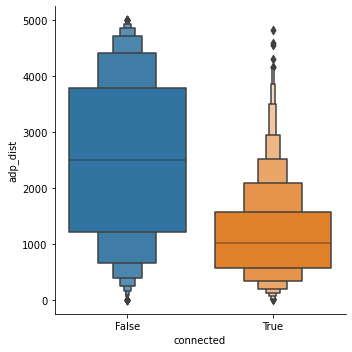

In [10]:
sns.catplot(data=data, x='connected', y='adp_dist', kind='boxen')

Neurons that form a synpase ('connected') tend to be closer together (smaller distance between pre- and post-synaptic ADP - 'adp_dist').

## Example: Basic Feature Engineering

### Exploration: Neurons that form a synpase tend to have similar functional neural responses

Neurons in the visual cortex each respond differently to visual stimuli.  This is often captured by a neuron's tuning function, or the visual features that drive a neuron to fire.  The feature weight vectors ('feature_weights') are a kind of summary of each neuron's tuning function.  Neuroscience suggests that neurons with similar tuning are slightly more likely to be connected.  To assess this, we would need to engineer a new feature that capture the tuning similarity of the pre- and post- synaptic neurons for each ADP.  (See the documentation for more details).  

In [11]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [12]:
# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)

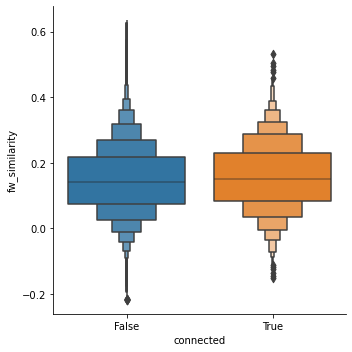

In [13]:
#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen')

There may be a very, very slight difference, but we can investigate this further.

### Exploration: Similar functional nerual responses by projection region in the brain

Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

In [14]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

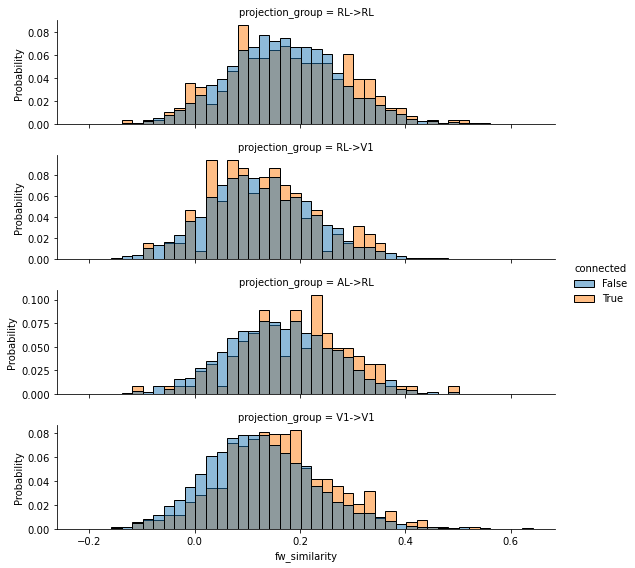

In [15]:
# check the distribution of the cosine similarity for projections groups with more than 100 synapses
projection_group_counts = data.query('connected')['projection_group'].value_counts()
projection_group_counts = projection_group_counts[projection_group_counts > 100].index
sns.displot(
    data=data.query('projection_group in @projection_group_counts'), 
    x='fw_similarity', 
    hue='connected', 
    row='projection_group',
    common_norm=False, 
    stat='probability',
    binwidth=.02,
    height=2,
    aspect=4,
    facet_kws={'sharey': False}
)

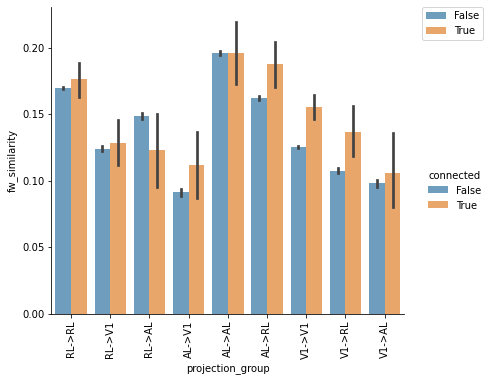

In [16]:
sns.catplot(data=data, x='projection_group', y='fw_similarity', hue='connected', kind='bar', alpha=.7)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

We have shown some simple examples of how to engineer new features and also shown that these are related to neuron connectivity.  You will likley need to explore and engineer many other possible features in this competition.  

In [17]:
# Let's engineer some features for projection regions
one_hot = pd.get_dummies(data['projection_group'], prefix='proj_grp')
df = pd.concat([data, one_hot], axis=1)
prj_cols = [col for col in df.columns if 'proj_grp' in col]
prj_cols

['proj_grp_AL->AL',
 'proj_grp_AL->RL',
 'proj_grp_AL->V1',
 'proj_grp_RL->AL',
 'proj_grp_RL->RL',
 'proj_grp_RL->V1',
 'proj_grp_V1->AL',
 'proj_grp_V1->RL',
 'proj_grp_V1->V1']

In [18]:
prj_cols = [col for col in df.columns if 'proj_grp' in col]
prj_cols

['proj_grp_AL->AL',
 'proj_grp_AL->RL',
 'proj_grp_AL->V1',
 'proj_grp_RL->AL',
 'proj_grp_RL->RL',
 'proj_grp_RL->V1',
 'proj_grp_V1->AL',
 'proj_grp_V1->RL',
 'proj_grp_V1->V1']

Now Engineer Feature for Pre-Post Soma-to-soma distance

In [19]:
df['sts_dist'] = abs(df['pre_skeletal_distance_to_soma'] - df['post_skeletal_distance_to_soma'])


Engineer Feature for distance between pre-post nucleus

In [20]:
def nucleus_distance(row):
    pre_coords = np.array([row['pre_nucleus_x'], row['pre_nucleus_y'], row['pre_nucleus_z']])
    post_coords = np.array([row['post_nucleus_x'], row['post_nucleus_y'], row['post_nucleus_z']])
    return np.linalg.norm(pre_coords - post_coords)

df['nucleus_distance'] = df.apply(nucleus_distance, axis=1)

In [21]:
def morphological_similarity(row):
    pre_morph = np.array(row["pre_morph_embeddings"])
    post_morph = np.array(row["post_morph_embeddings"])
    
    # Replace NaNs with zero
    pre_morph = np.nan_to_num(pre_morph)
    post_morph = np.nan_to_num(post_morph)
    
    norm_pre = np.linalg.norm(pre_morph)
    norm_post = np.linalg.norm(post_morph)
    
    if norm_pre == 0 or norm_post == 0:
        return 0.0
    
    return (pre_morph * post_morph).sum() / (norm_pre * norm_post)

# # Apply the function row-wise
# df['morph_sim'] = df.apply(morphological_similarity, axis=1)
# df['morph_sim'].unique()
# def morphological_similarity(row):
#     pre_morph = np.array(row["pre_morph_embeddings"])
#     post_morph = np.array(row["post_morph_embeddings"])
    
#     if np.isnan(pre_morph).any() or np.isnan(post_morph).any():
#         return 0.0  # or you can return some other value here
    
#     return (pre_morph * post_morph).sum() / (np.linalg.norm(pre_morph) * np.linalg.norm(post_morph))

# Apply the function row-wise
df['morph_sim'] = df.apply(morphological_similarity, axis=1)
# df.columns

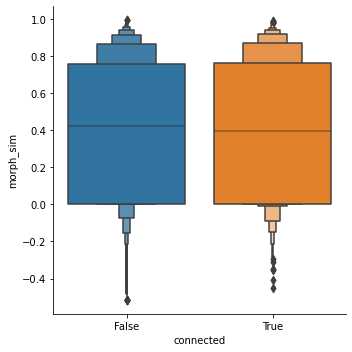

In [22]:
sns.catplot(data=df, x='connected', y='morph_sim', kind='boxen')

In [23]:
df['oracle_diff'] = np.abs(df['pre_oracle'] - df['post_oracle'])

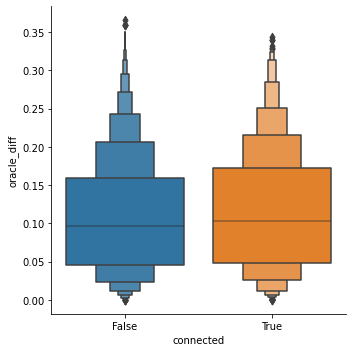

In [24]:
sns.catplot(data=df, x='connected', y='oracle_diff', kind='boxen')


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

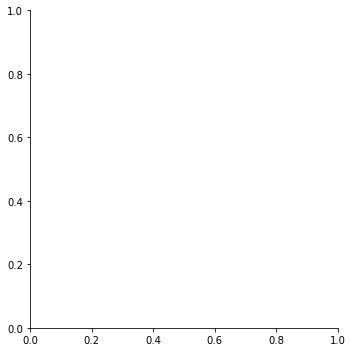

In [77]:
sns.catplot(data=data, x='compartment', y='connected', kind='boxen')


## Example: Simple Logistic Regression

Now that we have shown some features are associated with neuron connectivity, we fit a simple calssification model: Logistic Regression.

In [56]:
# logistic regression model (connected ~ fw_similarity + adp)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=2))
])

# Define the parameter grid to search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}


In [57]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1)

# Initialize GridSearchCV
grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(train_data[["fw_similarity", "adp_dist"] + prj_cols], train_data["connected"])

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on test data
test_data['pred'] = best_model.predict(test_data[["fw_similarity", "adp_dist"] + prj_cols])
# fit model
pipe.fit(train_data[["fw_similarity", "adp_dist"] + prj_cols], train_data["connected"])

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist"] + prj_cols])[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
accuracy: 0.9926009632200609


In [58]:
best_model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model',
   RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                          random_state=2))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                        random_state=2),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__bootstrap': True,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': 20,
 'model__max_features': 'auto',
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 10,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 200,
 'model__n_jobs': None,
 'model__oob_score': False,
 'model__random_state': 2,
 'model__verbose': 0,
 'model__warm_start': False}

Wow.  This looks like terrific accuracy.  But, remember the data is unbalanced.  Let's check the confusion matrix.

In [59]:
confusion_matrix(test_data['connected'], test_data['pred'] > .5)

array([[36892,     4],
       [  271,     0]])

The model always predicts not connected!  We need a new evaluation metric.

### Balanced Accuracy Metric

Sensitivity = True Positive Rate = True Positive / (True Positive + False Negative)
Specificity = True Negative Rate = True Negative / (True Negative + False Positive)

Balanced Accuracy = (Sensitivity + Specificity)/2

In [60]:
# no data augmentation results
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)
test_data['pred'].describe()

balanced accuracy: 0.4999457935819601


count    37167.000000
mean         0.007323
std          0.030021
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.580000
Name: pred, dtype: float64

In [ ]:
'''
PIPELINE FOR RANDOM FORESTS
# Create an imbalanced-learn pipeline
pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('sampling', SMOTE(random_state=2)),
    ('model', RandomForestClassifier(random_state=2))
])

# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
'''

'''
LOGISTIC REGRESSION
pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('sampling', SMOTE(random_state=2)),
    ('model', LogisticRegression(random_state=2))
])

# Define the parameter grid to search
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__penalty': ['l1', 'l2'],  # Regularization type
    'model__solver': ['liblinear', 'saga']  # Optimization algorithm
}
'''

In [69]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Create an imbalanced-learn pipeline with Logistic Regression


pipe = ImbPipeline([
    ('scaler', StandardScaler()),   # Feature scaling is critical for SVM
    ('sampling', SMOTE(random_state=2)),
    ('model', SVC(probability=True, random_state=2))  # probability=True for predict_proba
])

# Define the parameter grid to search
# param_grid = {
#     'model__C': [0.1, 1, 10],                 # Regularization parameter
#     'model__gamma': [0.001, 0.01, 0.1, 1],    # Kernel coefficient
#     'model__kernel': ['rbf']                  # Kernel type
# }
param_grid = {
    'model__C': [0.1, 1],                 # Regularization parameter
    'model__gamma': [0.01, 0.1],    # Kernel coefficient
    'model__kernel': ['linear']                  # Kernel type
}

train_data, test_data = train_test_split(df, test_size=0.2, random_state=1)

# Initialize RandomizedSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=3, n_jobs=-1)

# Fit RandomizedSearchCV to the training data
grid_search.fit(train_data[["fw_similarity", "adp_dist"] + prj_cols], train_data["connected"])

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on test data
test_data['pred'] = best_model.predict(test_data[["fw_similarity", "adp_dist"] + prj_cols])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [65]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('sampling', SMOTE(random_state=2)),
                ('model',
                 LogisticRegression(C=1, penalty='l1', random_state=2,
                                    solver='liblinear'))])

In [67]:
# Compute accuracy
accuracy = accuracy_score(test_data['connected'], test_data['pred'] > 0.5)
print(f"Accuracy: {accuracy}")

# Compute balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_data['connected'], test_data['pred'] > 0.5)
print(f"Balanced Accuracy: {balanced_accuracy}")

# Display the confusion matrix
conf_matrix = confusion_matrix(test_data['connected'], test_data['pred'] > 0.5)
print(conf_matrix)


Accuracy: 0.6628729787176797
Balanced Accuracy: 0.7386250532062997
[[24416 12480]
 [   50   221]]


## Data Augmentation for Unbalanced Classification

As our simple model always predicts not connected, we need to use some technique that balances the two classes.  While there are many strategies one can employ, we demostrate a simple random over sampling strategy that uses the bootstrap to augment the data for the minority ('connected') class.  

In [53]:
from imblearn.over_sampling import RandomOverSampler

# oversample connected neuron pairs
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    train_data[["fw_similarity", "adp_dist", ] + prj_cols], train_data["connected"]
)
# print(np.any(np.isnan(X_resampled)), np.any(np.isnan(y_resampled)))
# print(np.all(np.isfinite(X_resampled)), np.all(np.isfinite(y_resampled)))
# print(X_resampled.head(), y_resampled.head())


# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist", ] + prj_cols])[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

# confusion matrix
print(confusion_matrix(test_data['connected'], test_data['pred'] > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)

accuracy: 0.9911480614523637
[[36837    59]
 [  270     1]]
balanced accuracy: 0.501045473784096


In [ ]:
# Define the parameter distribution to sample from
param_distributions = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipe, param_distributions, n_iter=100, cv=5, verbose=1, n_jobs=-1, random_state=2)

# Fit RandomizedSearchCV to the training data
random_search.fit(train_data[["fw_similarity", "adp_dist"] + prj_cols], train_data["connected"])

# Get the best estimator
best_model = random_search.best_estimator_

# Predict on test data
test_data['pred'] = best_model.predict(test_data[["fw_similarity", "adp_dist"] + prj_cols])

Simple data augmentation improves our balanced accuracy dramatically!

# Create Example Prediction File for Leaderboard Submission

### Load and Merge Leaderboard Data

In [29]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [30]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [31]:
lb_data.shape
lb_data.head()

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,pre_nucleus_z,post_nucleus_x,post_nucleus_y,post_nucleus_z,pre_nucleus_id,post_nucleus_id,pre_feature_weights,post_feature_weights,pre_morph_embeddings,post_morph_embeddings
0,0,527499,544761,912282,529457,543459,916958,4783.37,239163.00,178032.0,...,861240,566528,777344,920800,582471,199477,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.03441501, 0.41964892, 0.23311342, 0.327173...","[0.5603107213973999, -0.3908874094486236, -0.1...","[1.132591724395752, -0.0064769592136144, -0.67..."
1,1,1269890,471870,837816,1271230,469651,841045,4060.72,294573.00,1193910.0,...,861240,1196352,492736,919560,582471,518848,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.5603107213973999, -0.3908874094486236, -0.1...","[1.0723994970321655, -0.7540942430496216, 0.11..."
2,2,666057,469875,925239,665387,467214,923430,2912.80,4102.75,387714.0,...,861240,669760,470336,913720,582471,256716,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.66653997, 0.5036552, 0.047438737, 0.181578...","[0.5603107213973999, -0.3908874094486236, -0.1...","[-0.0201839506626129, -0.2563340067863464, 0.1..."
3,3,696633,453516,925806,696648,453417,921875,3272.83,31123.00,424714.0,...,861240,669760,470336,913720,582471,256716,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.66653997, 0.5036552, 0.047438737, 0.181578...","[0.5603107213973999, -0.3908874094486236, -0.1...","[-0.0201839506626129, -0.2563340067863464, 0.1..."
4,4,567525,585921,888426,570714,583676,891264,4441.75,114201.00,250411.0,...,861240,672384,609728,932720,582471,260802,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.40308818, 0.20905656, 0.25083357, -0.19731...","[0.5603107213973999, -0.3908874094486236, -0.1...","[-0.0254557952284812, 0.7573301792144775, -0.2..."


### Example Prediction: Simple Logistic Regression

Now we fit a our logistic regression model on the full training data and use it to make predictions on the leaderboard data. But first, we need to add in our new engineered feature on neural tuning similarity.  

In [32]:
# compute the cosine similarity between the pre- and post- feature weights
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)

In [33]:
# compute OHE projections
# generate projection group as pre->post
lb_data["projection_group"] = (
    lb_data["pre_brain_area"].astype(str)
    + "->"
    + lb_data["post_brain_area"].astype(str)
)

one_hot = pd.get_dummies(lb_data['projection_group'], prefix='proj_grp')
lb_df = pd.concat([lb_data, one_hot], axis=1)
prj_cols = [col for col in lb_df.columns if 'proj_grp' in col]
prj_cols

['proj_grp_AL->AL',
 'proj_grp_AL->RL',
 'proj_grp_AL->V1',
 'proj_grp_RL->AL',
 'proj_grp_RL->RL',
 'proj_grp_RL->V1',
 'proj_grp_V1->AL',
 'proj_grp_V1->RL',
 'proj_grp_V1->V1']

In [34]:
lb_df = lb_df.drop(["projection_group"], axis=1)
lb_df.head()

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,fw_similarity,proj_grp_AL->AL,proj_grp_AL->RL,proj_grp_AL->V1,proj_grp_RL->AL,proj_grp_RL->RL,proj_grp_RL->V1,proj_grp_V1->AL,proj_grp_V1->RL,proj_grp_V1->V1
0,0,527499,544761,912282,529457,543459,916958,4783.37,239163.00,178032.0,...,-0.022573,0,0,1,0,0,0,0,0,0
1,1,1269890,471870,837816,1271230,469651,841045,4060.72,294573.00,1193910.0,...,0.353360,0,1,0,0,0,0,0,0,0
2,2,666057,469875,925239,665387,467214,923430,2912.80,4102.75,387714.0,...,0.052183,0,0,1,0,0,0,0,0,0
3,3,696633,453516,925806,696648,453417,921875,3272.83,31123.00,424714.0,...,0.052183,0,0,1,0,0,0,0,0,0
4,4,567525,585921,888426,570714,583676,891264,4441.75,114201.00,250411.0,...,0.009847,0,0,1,0,0,0,0,0,0


In [35]:
# oversample connected neuron pairs for full training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    train_data[["fw_similarity", "adp_dist"] + prj_cols], train_data["connected"]
)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on leaderboard data
lb_df["pred"] = pipe.predict_proba(lb_df[["fw_similarity", "adp_dist"] + prj_cols])[:, 1]

#create a boolean prediction solution
lb_df["connected"] = lb_df["pred"] > .5

### Example of Creating a Leaderboard Submission File

In [36]:
#columns should be ID, connected
submission_data = lb_df.filter(['ID','connected'])

In [37]:
submission_data

,ID,connected
0,0,False
1,1,False
2,2,False
3,3,False
4,4,False
...,...,...
42588,42588,True
42589,42589,False
42590,42590,False
42591,42591,False


In [38]:
#writing csv files
# submission_data.to_csv('example_submission_data.csv',index=False)

In [39]:
#!kaggle competitions submit -c neuron-synapse-prediction -f submission.csv -m "Message"